# Exploring data

**Abstract:** Reading the data and preprocessing it before we turn to our first attempts at training. Also have a look at the `training` directory in this repository, where we eventually ended up with the training methods.

## Preamble

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append("../")
import utils

from nmma.em.io import read_photometry_files
from nmma.em.utils import interpolate_nans
from nmma.em.utils import calc_lc_grb
from nmma.em.model import SVDLightCurveModel

import inspect 
import nmma.em.model_parameters as model_parameters

MODEL_FUNCTIONS = {
    k: v for k, v in model_parameters.__dict__.items() if inspect.isfunction(v)
}
MODEL_FUNCTIONS

params = {"axes.grid": True,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(params)

## Loading the data

In [49]:
data_location = "../preprocessing/"
X, freqs, times = utils.read_X_file(data_location + "X_afgpy.h5")
times = times / (3600 * 24) # convert time to days
Y = utils.read_Y_file(data_location + "Y_afgpy.h5")

lcdir = "../lcdir/"
filenames = os.listdir(lcdir)
full_filenames = [os.path.join(lcdir, f) for f in filenames]
print(f"There are {len(filenames)} files in the directory {lcdir}")

## Preprocessing the data

In [60]:
data = read_photometry_files(full_filenames)
data = interpolate_nans(data)

keys = list(data.keys())
filts = sorted(list(set(data[keys[0]].keys()) - {"t"}))
print(filts)

In [56]:
model_name = "afterglowpy_tophat"
model_function = MODEL_FUNCTIONS[model_name]

training_data, parameters = model_function(data)
keys = list(training_data.keys())
training_data_example = training_data[keys[0]]

for key in training_data:
    training_data[key]["t"] = times

## Getting the SVD model

In [58]:
lc_model = SVDLightCurveModel("afterglowpy_tophat",
                              times,
                              svd_path="/home/urash/twouters/new_nmma_models/afterglowpy",
                              interpolation_type="tensorflow",
                              local_only = True)

Loaded filter X-ray-1keV
Loaded filter X-ray-5keV
Loaded filter bessellv
Loaded filter radio-3GHz
Loaded filter radio-5.5GHz
Loaded filter radio-6GHz


## Compare the synthetic light curves

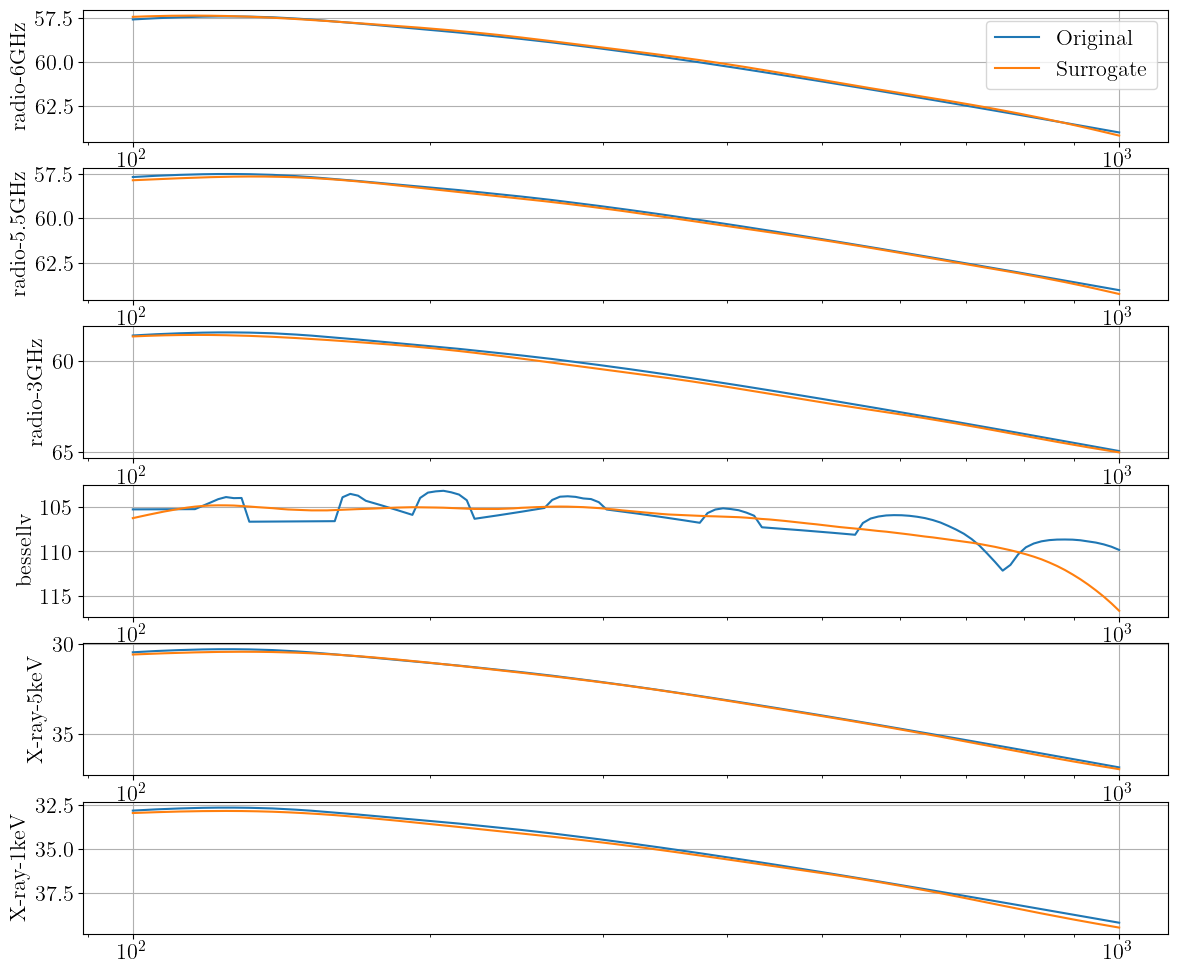

In [59]:
# Choose an index of the grid here
idx = 4002

# Get the original LC
keys = np.array(list(training_data.keys()))
example_name = keys[idx]
key = list(training_data.keys())[idx]
raw_lightcurve = training_data[example_name]

# Get the surrogate LC
example_parameters = [training_data[key][param] for param in parameters]
example_parameters = np.array(example_parameters)
t = times
_, _, mAB = calc_lc_grb(t,
                        example_parameters, 
                        svd_mag_model = lc_model.svd_mag_model, 
                        interpolation_type="tensorflow", 
                        filters = filts, 
                        mag_ncoeff = 10
)

nrows = len(filts)
plt.subplots(nrows = nrows, figsize=(14, 12))

for filt in filts:
    plt.subplot(nrows, 1, nrows - filts.index(filt))
    plt.plot(t, raw_lightcurve[filt], label="Original")
    plt.plot(t, mAB[filt], label="Surrogate")
    plt.ylabel(filt)
    plt.gca().invert_yaxis()
    plt.xscale("log")
plt.legend()
plt.show()